# Libraries.

In [ ]:
#Pre-requisite Installation.
!pip install xgboost
!pip install kaggle
!pip install imbalanced-learn
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.1/599.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.8/351.8 kB 23.9 MB/s eta 0:00:00


In [ ]:
#Import Libraries for file manipulation.
import pandas as pd
import numpy as np

#Import libraries for Data visualization.
import seaborn as sns
from matplotlib import pyplot as plt

#Import libraries for model performance metrics.
from sklearn.metrics import classification_report, accuracy_score

#Import libraries for model training.
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib

#Import libraries for chatGPT integration
from openai import OpenAI
import os

# Data Exploration
This dataset is comprised of 25011003 records and 22 features categorizing activity in network traffic as normal or malicious. The malicious activity can be labeled as Attack, DDoS, Command & Control, Part of Horizaontal Scan, and File Download.

In [ ]:
#Download dataset from Kaggle.
! kaggle datasets download agungpambudi/network-malware-detection-connection-analysis

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [ ]:
#Unzip the dataset zip file and concatenate all csv files into one dataframe, iot_intrusion_dataset.
from zipfile import ZipFile

zip = ZipFile('/content/network-malware-detection-connection-analysis.zip', 'r')
dfs = []
for n in zip.namelist():
  if n.endswith('.csv'):
    chunk_iter = pd.read_csv(zip.open(n), sep='|', header=0, chunksize=10000)
    for chunk in chunk_iter:
      dfs.append(chunk)
zip.close()

iot_intrusion_dataset = pd.concat(dfs)

#Shuffle dataframe and reset index.
iot_intrusion_dataset = iot_intrusion_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
#Print the number of rows and features in the dataset.
iot_intrusion_dataset.shape

(25011003, 23)

In [ ]:
#Print the first five records in the dataset.
iot_intrusion_dataset.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
0,1.545458e+09,CRpZTx3QpREBLMkU84,192.168.1.196,33602.0,119.40.38.73,23.0,tcp,-,3.114746,0,...,-,0.0,S,3.0,180.0,0.0,0.0,-,Benign,-
1,1.532527e+09,CsluWx47bsMLEPPlO2,192.168.100.111,56675.0,39.213.84.34,23.0,tcp,-,-,-,...,-,0.0,S,1.0,40.0,0.0,0.0,-,Malicious,PartOfAHorizontalPortScan
2,1.545436e+09,CHviE841AgX44xSg0a,192.168.1.196,46128.0,159.229.153.210,23.0,tcp,-,-,-,...,-,0.0,S,1.0,60.0,0.0,0.0,-,Benign,-
3,1.532563e+09,Cm2xso4ZbrYhknvWbk,192.168.100.111,5135.0,147.32.46.208,23.0,tcp,-,-,-,...,-,0.0,S,1.0,40.0,0.0,0.0,-,Malicious,PartOfAHorizontalPortScan
4,1.569018e+09,ClPyQZ2l6aBFqUmp3b,192.168.1.195,22747.0,162.248.88.215,62336.0,tcp,-,-,-,...,-,0.0,C,0.0,0.0,0.0,0.0,-,Malicious DDoS,NaN


In [ ]:
#Print the columns/features of the dataset.
print(iot_intrusion_dataset.columns)

Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history',
       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes',
       'tunnel_parents', 'label', 'detailed-label'],
      dtype='object')


In [ ]:
#Print the unique labels in the dataset.
iot_intrusion_dataset["label"].unique()

array(['Benign', 'Malicious', 'Malicious   DDoS',
       'Malicious   PartOfAHorizontalPortScan', 'Malicious   Attack',
       'Malicious   C&C', 'Malicious   FileDownload'], dtype=object)

In [ ]:
#Print count of records associated with each label in the dataset.
label_count = iot_intrusion_dataset['label'].value_counts()
print(label_count)

label
Benign                                   8780158
Malicious                                7055007
Malicious   DDoS                         5778154
Malicious   PartOfAHorizontalPortScan    3386241
Malicious   C&C                             8685
Malicious   Attack                          2755
Malicious   FileDownload                       3
Name: count, dtype: int64


In [ ]:
#Print the unique detailed labels in the dataset.
iot_intrusion_dataset["detailed-label"].unique()

array(['-', 'PartOfAHorizontalPortScan', nan, 'Attack', 'HeartBeat',
       'C&C', 'Torii', 'FileDownload'], dtype=object)

In [ ]:
#Print count of records where label is malicious and detailed-label is C&C.
#Print count of records where label is malicious and detailed-label is PartOfAHorizontalPortScan.
count_cc = len(iot_intrusion_dataset[(iot_intrusion_dataset['label'] == 'Malicious') & (iot_intrusion_dataset['detailed-label'] == 'C&C')])
count_partofhorizontalscan = len(iot_intrusion_dataset[(iot_intrusion_dataset['label'] == 'Malicious') & (iot_intrusion_dataset['detailed-label'] == 'PartOfAHorizontalPortScan')])

print(f"Number of records where label is malicious and detailed-label is C&C: {count_cc}")
print(f"Number of records where label is malicious and detailed-label is PartofHorizontalScan: {count_partofhorizontalscan}")

Number of records where label is malicious and detailed-label is C&C: 8238
Number of records where label is malicious and detailed-label is PartofHorizontalScan: 7040807


In [ ]:
#Replace 'Malicious' with 'Malicious C&C' where 'label' is 'malicious' and 'detailed-label' is 'C&C'
#Replace 'Malicious' with 'Malicious PartofAHorizontalPortScan' where 'label' is 'malicious' and 'detailed-label' is 'PartofHorizontalScan'
iot_intrusion_dataset.loc[(iot_intrusion_dataset['label'] == 'Malicious') & (iot_intrusion_dataset['detailed-label'] == 'C&C'), 'label'] = 'Malicious   C&C'

iot_intrusion_dataset.loc[(iot_intrusion_dataset['label'] == 'Malicious') & (iot_intrusion_dataset['detailed-label'] == 'PartOfAHorizontalPortScan'), 'label'] = 'Malicious   PartOfAHorizontalPortScan'

In [ ]:
#Print count of records associated with each label in the dataset.
label_count = iot_intrusion_dataset['label'].value_counts()
print(label_count)

label
Malicious   PartOfAHorizontalPortScan    10427048
Benign                                    8780158
Malicious   DDoS                          5778154
Malicious   C&C                             16923
Malicious                                    5962
Malicious   Attack                           2755
Malicious   FileDownload                        3
Name: count, dtype: int64


In [ ]:
#Check for missing values.
#Replace character '-' with NaN and print the count of null/Nan values for each column/feature.
iot_intrusion_dataset.replace('-', pd.NA, inplace=True)
null_values = iot_intrusion_dataset.isnull().sum()
print(null_values)

ts                       0
uid                      0
id.orig_h                0
id.orig_p                0
id.resp_h                0
id.resp_p                0
proto                    0
service           24993006
duration          15272073
orig_bytes        15272073
resp_bytes        15272073
conn_state               0
local_orig        25011003
local_resp        25011003
missed_bytes             0
history              25116
orig_pkts                0
orig_ip_bytes            0
resp_pkts                0
resp_ip_bytes            0
tunnel_parents    25011003
label                    0
detailed-label    17954112
dtype: int64


In [ ]:
#Print the percentage that null/Nan values represent for each column in the dataset.
missing_values_percentage = iot_intrusion_dataset.isna().mean() * 100
print(missing_values_percentage)

ts                  0.000000
uid                 0.000000
id.orig_h           0.000000
id.orig_p           0.000000
id.resp_h           0.000000
id.resp_p           0.000000
proto               0.000000
service            99.928044
duration           61.061418
orig_bytes         61.061418
resp_bytes         61.061418
conn_state          0.000000
local_orig        100.000000
local_resp        100.000000
missed_bytes        0.000000
history             0.100420
orig_pkts           0.000000
orig_ip_bytes       0.000000
resp_pkts           0.000000
resp_ip_bytes       0.000000
tunnel_parents    100.000000
label               0.000000
detailed-label     71.784854
dtype: float64


In [ ]:
#Drop all columns with null values.
iot_intrusion_dataset.drop(["detailed-label", "service", "duration", "orig_bytes", "resp_bytes", "local_orig", "local_resp", "tunnel_parents", "history"], axis=1, inplace=True)

In [ ]:
#Print the percentage of null/Nan values for each column in the dataset after dropping columns.
missing_values_percentage = iot_intrusion_dataset.isna().mean() * 100
print(missing_values_percentage)

ts               0.0
uid              0.0
id.orig_h        0.0
id.orig_p        0.0
id.resp_h        0.0
id.resp_p        0.0
proto            0.0
conn_state       0.0
missed_bytes     0.0
orig_pkts        0.0
orig_ip_bytes    0.0
resp_pkts        0.0
resp_ip_bytes    0.0
label            0.0
dtype: float64


In [ ]:
#Print number of records and features in the dataset
iot_intrusion_dataset.shape

(25011003, 14)

In [ ]:
#Check for duplicates in the dataset.
iot_intrusion_dataset.duplicated().sum()

0

# Dataset Consistency Check

This section evaluates if the dataset is balanced or imbalanced based on the number of records associated with each label. We can conclude that the dataset is not balanced. There are fewer records for 'Malicious', 'Malicious C&C', 'Malicious DDoS' and 'Malicious Attack' labels.

In [ ]:
#Print count of records associated with each label in the dataset.
label_count = iot_intrusion_dataset['label'].value_counts()
print(label_count)

label
Malicious   PartOfAHorizontalPortScan    10427048
Benign                                    8780158
Malicious   DDoS                          5778154
Malicious   C&C                             16923
Malicious                                    5962
Malicious   Attack                           2755
Malicious   FileDownload                        3
Name: count, dtype: int64


<ipython-input-21-c19c81f2adcc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=iot_intrusion_dataset, x='label', palette='deep')


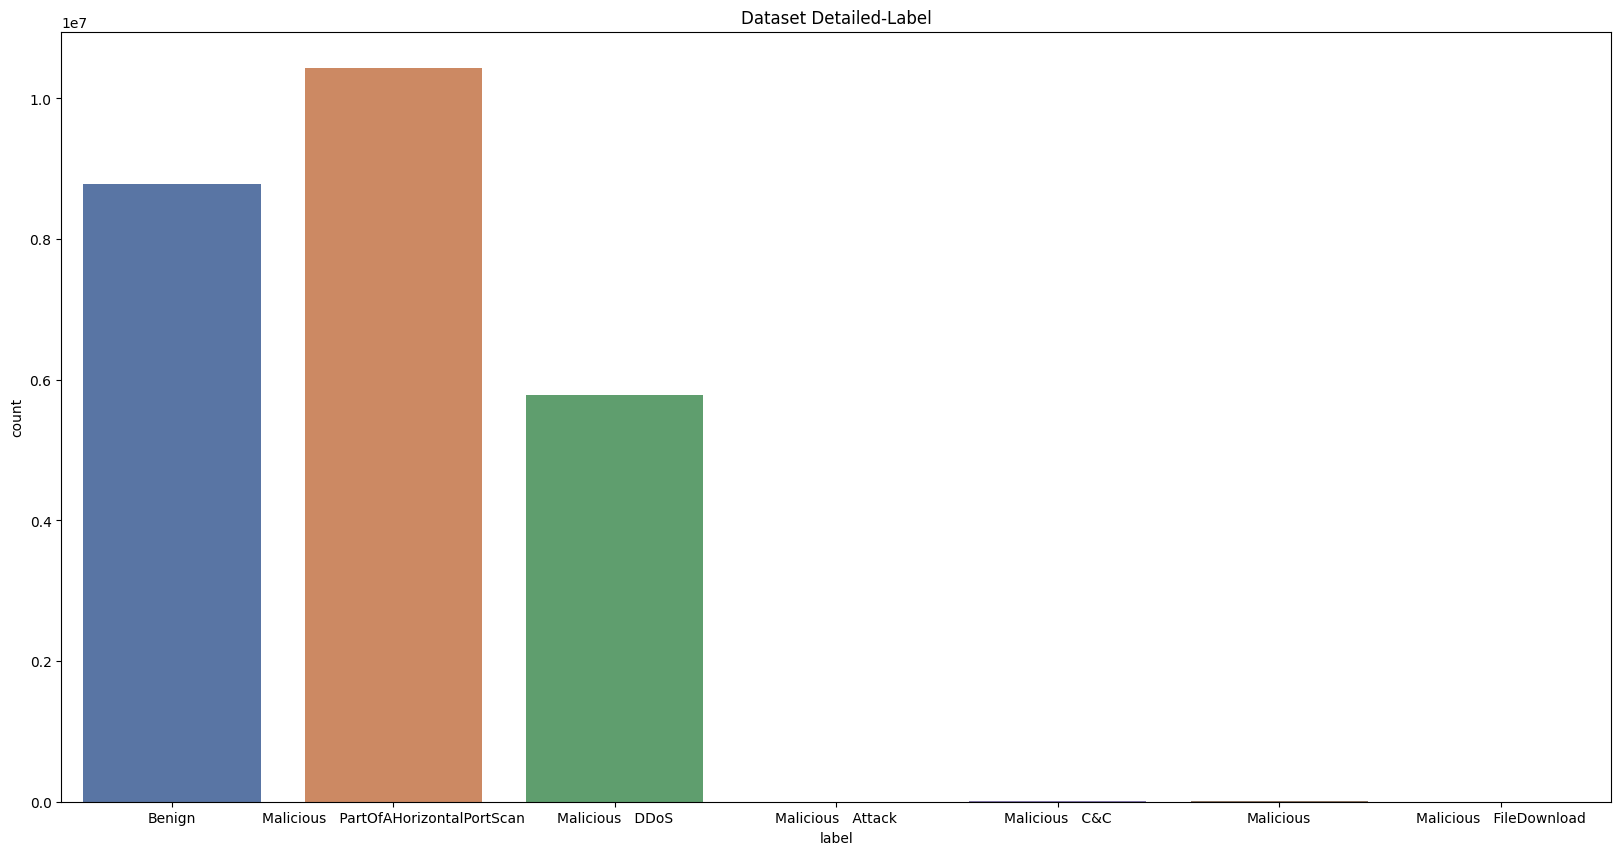

In [ ]:
#Create count plot to visualize the distribution of the 'label' column in the dataset.
plt.figure(figsize=(20,10))
plt.title("Dataset Detailed-Label")
sns.countplot(data=iot_intrusion_dataset, x='label', palette='deep')
plt.show()

In [ ]:
#Determine the indices of the rows where label='Malicious   FileDownload', 'Malicious Attack'.
#Drop those rows.
labels_to_include = ['Malicious   Attack', 'Malicious   FileDownload', 'Malicious   C&C', 'Malicious']
rows_to_drop = iot_intrusion_dataset[iot_intrusion_dataset['label'].isin(labels_to_include)].index
iot_intrusion_dataset.drop(rows_to_drop, inplace=True)

# Feature Engineering
In this section, we use label encoding to transform string and object data types into numeric data.


In [ ]:
iot_intrusion_dataset.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,1.545458e+09,CRpZTx3QpREBLMkU84,192.168.1.196,33602.0,119.40.38.73,23.0,tcp,S0,0.0,3.0,180.0,0.0,0.0,Benign
1,1.532527e+09,CsluWx47bsMLEPPlO2,192.168.100.111,56675.0,39.213.84.34,23.0,tcp,S0,0.0,1.0,40.0,0.0,0.0,Malicious PartOfAHorizontalPortScan
2,1.545436e+09,CHviE841AgX44xSg0a,192.168.1.196,46128.0,159.229.153.210,23.0,tcp,S0,0.0,1.0,60.0,0.0,0.0,Benign
3,1.532563e+09,Cm2xso4ZbrYhknvWbk,192.168.100.111,5135.0,147.32.46.208,23.0,tcp,S0,0.0,1.0,40.0,0.0,0.0,Malicious PartOfAHorizontalPortScan
4,1.569018e+09,ClPyQZ2l6aBFqUmp3b,192.168.1.195,22747.0,162.248.88.215,62336.0,tcp,OTH,0.0,0.0,0.0,0.0,0.0,Malicious DDoS


In [ ]:
#Define transform(label) function to encode the labels in the dataset and apply the transform to the labels.
def transform(label):
  if label == 'Benign': return 0
  if label == 'Malicious   PartOfAHorizontalPortScan': return 1
  return 2

iot_intrusion_dataset['label'] = iot_intrusion_dataset['label'].apply(transform)

In [ ]:
#Create an instance label_encoder to transform string or object data into numeric data.
label_encoder = LabelEncoder()

In [ ]:
#Tranform the 'uid' column into a numerical label for model processing.
iot_intrusion_dataset['uid'] = label_encoder.fit_transform(iot_intrusion_dataset['uid'])

In [ ]:
#Tranform the 'proto' column into a numerical label for model processing.
iot_intrusion_dataset['proto'] = label_encoder.fit_transform(iot_intrusion_dataset['proto'])

In [ ]:
#Tranform the 'conn-state' column into a numerical label for model processing.
iot_intrusion_dataset['conn_state'] = label_encoder.fit_transform(iot_intrusion_dataset['conn_state'])

In [ ]:
#Tranform the 'id.orig_h' column into a numerical label for model processing.
iot_intrusion_dataset['id.orig_h'] = label_encoder.fit_transform(iot_intrusion_dataset['id.orig_h'])

In [ ]:
#Tranform the 'id.resp_h' column into a numerical label for model processing.
iot_intrusion_dataset['id.resp_h'] = label_encoder.fit_transform(iot_intrusion_dataset['id.resp_h'])

In [ ]:
iot_intrusion_dataset.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,1.545458e+09,11213415,8933,33602.0,1231494,23.0,1,6,0.0,3.0,180.0,0.0,0.0,0
1,1.532527e+09,22074121,8940,56675.0,8622471,23.0,1,6,0.0,1.0,40.0,0.0,0.0,1
2,1.545436e+09,7225562,8933,46128.0,3997292,23.0,1,6,0.0,1.0,60.0,0.0,0.0,0
3,1.532563e+09,19361674,8940,5135.0,3171459,23.0,1,6,0.0,1.0,40.0,0.0,0.0,1
4,1.569018e+09,19107733,8932,22747.0,4209073,62336.0,1,0,0.0,0.0,0.0,0.0,0.0,2


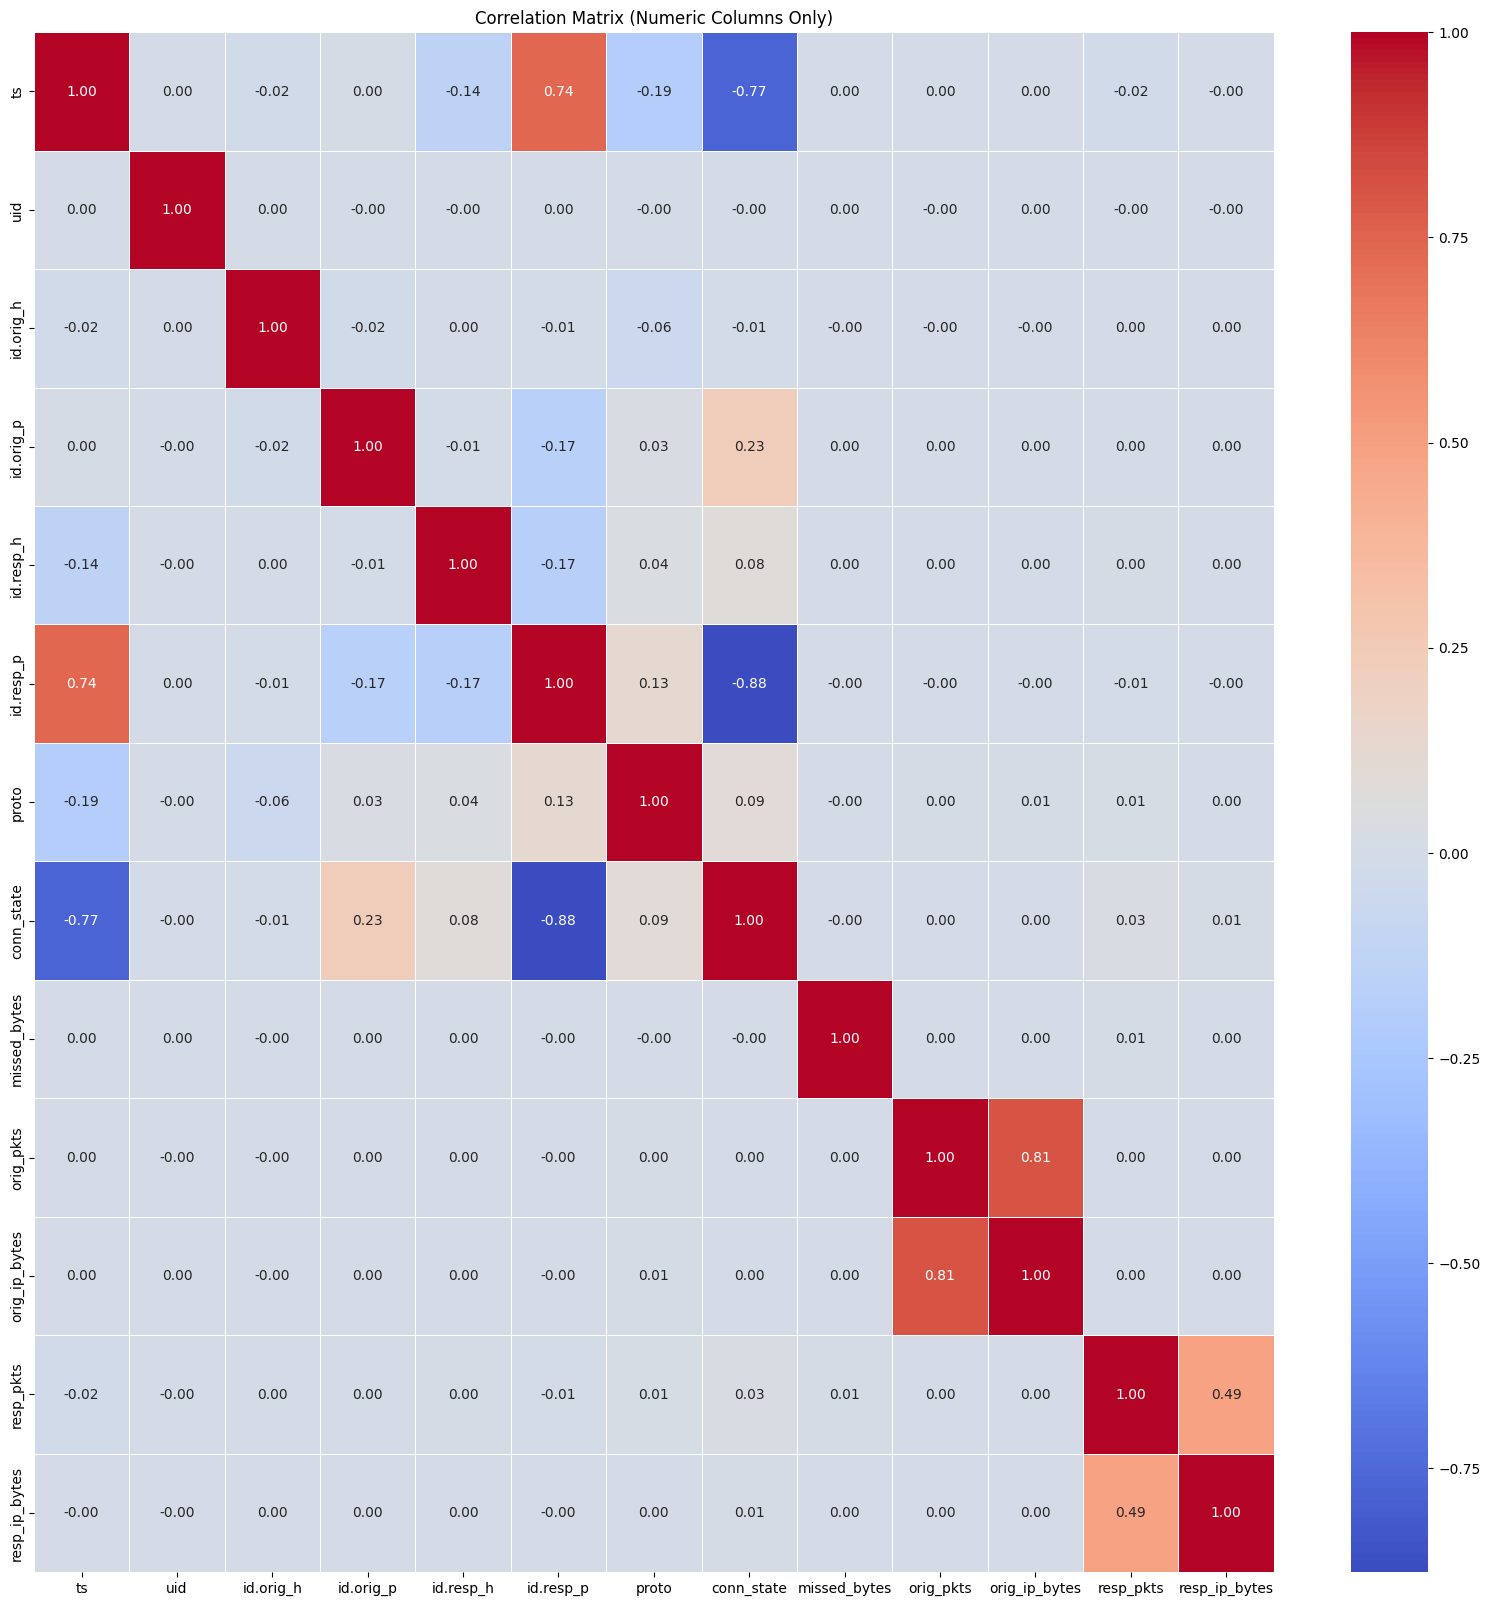

In [ ]:
#Correlation Matrix
comp_data = iot_intrusion_dataset.drop(['label'], axis=1)
correlation_matrix = comp_data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Numeric Columns Only)")
plt.show()

# Model Training
In this section, we are training a Random Forest model, XGboost classifier and logistic regression model able to detect malicious activity in a network of IoT devices.

In [ ]:
# Separate the dataset into features (X) and target variable (Y)
# train_dataset contains all features except 'label'
# target contains the target "label" column
train_dataset = iot_intrusion_dataset.drop(['label'], axis=1)
train_dataset.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
0,1.545458e+09,11213415,8933,33602.0,1231494,23.0,1,6,0.0,3.0,180.0,0.0,0.0
1,1.532527e+09,22074121,8940,56675.0,8622471,23.0,1,6,0.0,1.0,40.0,0.0,0.0
2,1.545436e+09,7225562,8933,46128.0,3997292,23.0,1,6,0.0,1.0,60.0,0.0,0.0
3,1.532563e+09,19361674,8940,5135.0,3171459,23.0,1,6,0.0,1.0,40.0,0.0,0.0
4,1.569018e+09,19107733,8932,22747.0,4209073,62336.0,1,0,0.0,0.0,0.0,0.0,0.0


In [ ]:
target = iot_intrusion_dataset['label']

In [ ]:
#Split the train_dataset into train values and test values.
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(train_dataset, target, test_size=0.2, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(19988288, 13)
(4997072, 13)


In [ ]:
X_test[:5]


array([[-1.07600135e+00,  1.58540541e+00,  1.65057937e-02,
        -7.09436744e-01,  7.55457761e-01, -4.36932971e-01,
        -1.22988891e-01,  5.18684532e-01, -7.78083072e-04,
        -6.74639195e-04, -7.68358156e-04, -1.70796626e-02,
        -2.80450293e-03],
       [-1.07513304e+00,  4.20625634e-02,  1.65057937e-02,
        -2.26398611e+00,  3.36546547e-01, -4.36932971e-01,
        -1.22988891e-01,  5.18684532e-01, -7.78083072e-04,
        -6.74639195e-04, -7.68358156e-04, -1.70796626e-02,
        -2.80450293e-03],
       [-1.07130626e+00, -1.54943018e+00,  1.65057937e-02,
        -1.43297990e+00,  1.17288529e+00, -4.36932971e-01,
        -1.22988891e-01,  5.18684532e-01, -7.78083072e-04,
        -6.74639195e-04, -7.68358156e-04, -1.70796626e-02,
        -2.80450293e-03],
       [ 1.65550047e-03,  2.81651239e-01, -1.86210111e-02,
         1.16060676e+00, -4.15489737e-01, -4.36932971e-01,
        -1.22988891e-01,  5.18684532e-01, -7.78083072e-04,
        -5.67853585e-04, -5.43786037e

In [ ]:
y_test[:5]

,label
21684971,1
11683419,1
13845018,1
14424130,0
20191592,2


In [ ]:
#Initiate an instance of Random Forest Classifier, forest_classifier.
forest_classifier = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=15)

#Train the model on training set and evaluate on testing set.
forest_classifier.fit(X_train, y_train)
y_pred = forest_classifier.predict(X_test)

#Compute and print performance metrics.
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")
print(f"Classication Report: \n{classification_report(y_test, y_pred, digits=4)}")

Accuracy: 0.9998020841004492

Classication Report: 
              precision    recall  f1-score   support

           0     1.0000    0.9994    0.9997   1755451
           1     0.9995    1.0000    0.9998   2084915
           2     1.0000    1.0000    1.0000   1156706

    accuracy                         0.9998   4997072
   macro avg     0.9998    0.9998    0.9998   4997072
weighted avg     0.9998    0.9998    0.9998   4997072



In [ ]:
# Save the trained Random Forest model
joblib.dump(forest_classifier, 'iot_detection_model.pkl')
print("Model saved successfully!")

Model saved successfully!


# Integration of LLM Agent

In [ ]:
#Load a client instance
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

In [ ]:
def generate_llm_response(messages):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )
    chatbot_response = response.choices[0].message.content
    print(chatbot_response)

In [ ]:
def end_conversation():
  end_conversation_message ={
        "role": "system",
        "content": "Say Goodbye, and let them know they can reach out again if you need any help in the future."
    }
  messages = [end_conversation_message]
  generate_llm_response(messages)

In [ ]:
def ask_for_further_help():
  while True:
    user_input = input("\nAgent: Is there anything else I can help you with? (yes/no): ")
    if user_input.lower() in ["yes", "sure"]:
      follow_up_input = input("\nWhat else would you like help with? Please describe your issue: ")
      assistant_message = [{
              "role": "system",
              "content": f"User mentioned they need assistance with: '{follow_up_input}'. What specific information or help can I provide based on this?"
          }]
      generate_llm_response(assistant_message)

    elif user_input.lower() in ["no", "thank you", "goodbye", "exit"]:
      #print("\nAgent: Goodbye, and feel free to reach out again if you need any help in the future.")
      end_conversation()
      break

In [ ]:
def get_llm_insights(result, confidence_score):

  system_message = {
        "role": "system",
        "content": f"You are a network security analyst tasked with providing insights into IoT traffic in a home network to a homeowner. "
                   f"Based on the machine learning model's prediction, the traffic from IoT device on the network is classified as {result} "
                   f"where 0 is Normal, 1 is Malicious PartOfAHorizontalPortScan and 2 is Malicious DDoS with a confidence score of {confidence_score}. "
                   "The model used the following features:\n"
                   "- Feature 1: ts, the timestamp of the connection event.\n"
                   "- Feature 2: uid, a unique identifier for the connection.\n"
                   "- Feature 3: id.orig_h, the source IP address.\n"
                   "- Feature 4: id.orig_p, the source port.\n"
                   "- Feature 5: id.resp_h, the destination IP address.\n"
                   "- Feature 6: id.resp_p, the destination port.\n"
                   "- Feature 7: proto, the network protocol used.\n"
                   "- Feature 8: conn_state, the state of the connection.\n"
                   "- Feature 9: missed_bytes, the number of missed bytes in the connection.\n"
                   "- Feature 10: orig_pkts, the number of packets sent from the source to the destination.\n"
                   "- Feature 11: orig_ip_bytes, the number of IP bytes sent from the source to the destination.\n"
                   "- Feature 12: resp_pkts, the number of packets sent from the destination to the source.\n"
                   "- Feature 13: resp_ip_bytes, the number of IP bytes sent from the destination to the source.\n"
                   "Can you provide an explanation or insights into this prediction?"}

  details_message ={
      "role": "user",
      "content": "Provide brief details on the behavior detected on the network in simple terms without referring to the machine learning model."
  }
  messages = [system_message, details_message]
  generate_llm_response(messages)

  user_input = input("\nAgent: Do you want recommendations on how to resolve this issue? (yes/no): ")
  if user_input.lower() in ["yes", "sure"]:
    recommendation_message = {
            "role": "user",
            "content": "Yes, please provide top 3 recommendations and explain in simple terms for the home owner."
        }
    messages = [system_message, recommendation_message]
    generate_llm_response(messages)
    ask_for_further_help()
  else:
    ask_for_further_help()

In [ ]:
#Load the intrusion detection model
detection_model = joblib.load('iot_detection_model.pkl')

#Make predictions on new data
data_sample = [[2.17727140e-03, -9.72114052e-01, -1.84613743e-02,
        -1.53322810e+00,  1.20889079e+00, -3.93404677e-01,
        -1.22941497e-01, -8.48923118e-01, -2.23680995e-04,
        -5.78956723e-04, -6.58342430e-04, -1.70883811e-02,
        -3.09063709e-03]]
prediction = detection_model.predict(data_sample)
confidence_scores = detection_model.predict_proba(data_sample)
predicted_label = prediction[0]
print(prediction)
prediction_confidence_score = confidence_scores[0][predicted_label]
if predicted_label == 1 or predicted_label == 2:
  print("Agent: Hello! I'm your network security assistant. Suspicious activity has been detected on the network and I'm here to help.")
  llm_insights = get_llm_insights(predicted_label, prediction_confidence_score)
else:
   print("Agent: Normal traffic behavior on the network. No LLM insights required.")

[2]
Agent: Hello! I'm your network security assistant. Suspicious activity has been detected on the network and I'm here to help.
The IoT device on your home network is exhibiting behavior consistent with a Distributed Denial of Service (DDoS) attack with a high level of confidence. This means that the device is likely being used to flood a target server or website with a large volume of traffic, making it unavailable to legitimate users. It is important to investigate and take actions to mitigate this malicious activity to protect your network and connected devices.

Agent: Do you want recommendations on how to resolve this issue? (yes/no): yes
Sure! Here are the top 3 recommendations along with simple explanations for the homeowner based on the prediction of malicious DDoS traffic from an IoT device on the home network:

1. **Identify and isolate the IoT device**: Look for any IoT devices that might be behaving suspiciously or consuming a lot of network resources. Once identified, is